hello $e^{i\pi} + 1 = 0$

# Methodology

## VERSION 1

In [ ]:
%%writefile /projects/s21/ba13026/Notebooks/Protocols/conduc_meter_library_test.py
#!/usr/bin/env python

import sys, os, numpy, itertools, subprocess

def indexes_and_coordinates(fname):
        # Test if index files already exist
        Atoms = ['P8', 'K', 'CL'] # Define atom names
        # Make individual index and trajectories files
        for atom in Atoms:
                print ('TESTING IF INDEX FILE FOR ATOM %s IS PRESENT IN CURRENT DIRECTORY ...\n'% (atom))
                if os.path.isfile(atom+'-Indexes_'+fname+'.ndx') == False:
                        print ('Index file does not exist for atom: '+atom+'\n')
                        print ('Index file will be created using GROMACS tool: make_ndx ...\n')
                        gmx_code0       = ['gmx','make_ndx','-f',fname+'.gro','-o',atom+'-Indexes_'+fname+'.ndx']
                        proc            = subprocess.Popen(gmx_code0, stdin=subprocess.PIPE)
                        proc.communicate(input = 'del 0-50\n a '+atom+'\n q\n')
                        proc.wait()
                else:
                        print('INDEX FILE %s ALREADY EXISTS! ...\n'% (atom+'-Indexes_'+fname+'.ndx'))

                print ('TESTING Z-COORDINATE FILE FOR ATOM %s IS PRESENT IN CURRENT DIRECTORY ...\n'% (atom))
                if os.path.isfile(atom+'-Zcoord_'+'PBC_'+fname+'.xvg') == False:
                        print ('File with Z-coordinate does not exist for atom: '+atom+'\n')
                        print ('Z-coordinates will be extracted using GROMACS tool: traj ...\n')
                        gmx_code1       = ['gmx','traj','-f',fname+'.xtc','-s',fname+'.tpr','-n',atom+'-Indexes_'+fname+'.ndx','-nox','-noy','-ox',atom+'-Zcoord_'+'PBC_'+fname+'.xvg']
                        subprocess.call(gmx_code1)
                        print ('Coordinates successfully extracted :)\n')
                        print ('Keep in mind that these coordinates are wrapped (not corrected by PBCs)\n')
                else:
                        print('Z-COORDINATE FILE %s ALREADY EXISTS!\n'% (atom+'-Zcoord_'+'PBC_'+fname+'.xvg') )

# Function to correct displacement by PBC
def pbc_distance(x,y,Lz):
    d = y - x
    if abs(d) <= Lz/float(2):
        return d
    else:
        return numpy.sign(d)*(abs(d)-Lz)

def find_P8end_coords(fname):
        #Average position of P8 atoms
        infile  = open('P8-Zcoord_'+'PBC_'+fname+'.xvg','r')    # Open file
        lines   = infile.readlines()    # Read lines
        N       = len(lines)    # Number of lines
        infile.close()
        mZ_P8_UP        = []
        mZ_P8_DOWN      = []
        for n in range(N):
                if  ("@" not in lines[n].rstrip()) and ("#" not in lines[n].rstrip()):
                        Z_P8    = map(float, lines[n].rstrip().split()[1:]) # Z-ccordinates P8 atoms
                        Z0      = numpy.mean(Z_P8)
                        mZ_P8_UP.append( numpy.mean([z for z in Z_P8 if z > Z0]) )
                        mZ_P8_DOWN.append( numpy.mean([z for z in Z_P8 if z < Z0]) )
        P8_UP, P8_DOWN = numpy.mean(mZ_P8_UP), numpy.mean(mZ_P8_DOWN)
        return P8_DOWN, P8_UP # P8-end coordinates [nm]

def instant_charge(fname, Lz, Z_min, Z_max):
        """This code computes both the instant normalised-charge [C/1.6E-19] permeated in time [ps], for each ion species."""
        permeations = {} # Relative permeations
        bthickness  = numpy.abs(Z_max - Z_min)
        for ion in ['K', 'CL']:
                # Load ion indexes
                ndxfile = open(ion+'-Indexes_'+fname+'.ndx')
                ion_ndx = list(itertools.chain.from_iterable([x.rstrip().split() for x in ndxfile.readlines()[1:]]))
                Nc      = len(ion_ndx)  # Number of ions
                ndxfile.close()

                # Trajectory file
                infile  = open(ion+'-Zcoord_'+'PBC_'+fname+'.xvg', 'r')
                lines   = infile.readlines()    # Read lines
                N       = len(lines)    # Number of lines
                infile.close()

                Time    =       []      # Time [ps]
                ICharge =       []      # 'Relative' permeation events (Instant charge)

                for n in range(N-1):
                        if  ("@" not in lines[n].rstrip()) and ("#" not in lines[n].rstrip()):
                                Time.append( float(lines[n+1].rstrip().split()[0]) )
                                # Z-coordinates of ions at time 't' (Current frame)
                                Z_t1      = map(float, lines[n].rstrip().split())
                                # Z-coordinates of ions at time 't+dt' (Next frame)
                                Z_t2      = map(float, lines[n+1].rstrip().split())
                                # List all pairs of coordinates per ion at times 't' and 't+dt'
                                Pairs   = [x for x in itertools.izip(Z_t1, Z_t2)]
                                # Compute Forward Displacement, correcting by PBCs
                                dZ      = [pbc_distance(x,y,Lz) for x,y in Pairs]
                                # Check if ions inside channel volume at time 't+dt'
                                State   = ['In'  if  Z_min <= x <= Z_max else 'Out' for x in Z_t2]
                                # Filtre displacement values of ions inside channel at time 't+dt'
                                dZ_in   = [dZ[k] if State[k]=='In' else 0 for k in range(len(dZ))]
                                # Compute 'relative' permeation events
                                ICharge.append( sum(dZ_in)/float(bthickness) ) # Instant Charge [C/1.6E-19]

                permeations[ion] = numpy.array([Time, ICharge]).T
        return permeations

In [ ]:
%%writefile /projects/s21/ba13026/Notebooks/Protocols/conduc_meter_channel_test.py
#!/usr/bin/env python

# Note: Modified version 18 Nov 2016
import sys, os, numpy, itertools, subprocess
from conduc_meter_library import *

fname   = sys.argv[1] # Generic name of simulation files
option  = sys.argv[2] # Output data option (Print or Save)

info    = subprocess.Popen(['tail','-1',fname+'.gro'],stdout=subprocess.PIPE)
box_dim = map(float,info.stdout.read().split()) # Box dimensions [nm ,nm, nm]
Lz      = box_dim[-1]   # Box Z-length [nm]

# Extract atom indexes and coordinates
indexes_and_coordinates(fname)
# End coordinates of bilayer leaflets [nm]
Z_min, Z_max    = find_P8end_coords(fname)
# Determine relative permeations
permeations = instant_charge(fname, Lz, Z_min, Z_max)

N       = len(permeations['K'])
if option == 'save':
        outfile = open(fname+'.cm_flux', 'w')
        for n in range(N):
                time       = permeations['K'][n][0]
                icharge_K  = permeations['K'][n][1]
                icharge_CL = permeations['CL'][n][1]
                outfile.write( str(time)+'\t'+str(icharge_K)+'\t'+str(icharge_CL)+'\n' )
        outfile.close()
elif option == 'print':
        for n in range(N):
                time       = permeations['K'][n][0]
                icharge_K  = permeations['K'][n][1]
                icharge_CL = permeations['CL'][n][1]
                print time, icharge_K, icharge_CL
else:
        print "Provide a valid option: 'save' or 'print'"


## VERSION 2

`conduct_meter_library`

In [ ]:
import sys
import os
import numpy
import itertools
import subprocess


def indexes_and_coordinates(fname):
    """Test if index files already exist"""
    Atoms = ['P8', 'K', 'CL'] # Define atom names
    # Make individual index and trajectories files
    for atom in Atoms:
            print ('TESTING IF INDEX FILE FOR ATOM %s IS PRESENT IN CURRENT DIRECTORY ...\n'% (atom))
            if os.path.isfile(atom+'-Indexes_'+fname+'.ndx') == False:
                print ('Index file does not exist for atom: '+atom+'\n')
                print ('Index file will be created using GROMACS tool: make_ndx ...\n')
                gmx_code0 = ['gmx','make_ndx',
                             '-f',fname+'.gro',
                             '-o',atom+'-Indexes_'+fname+'.ndx'
                            ]
                proc = subprocess.Popen(gmx_code0, stdin=subprocess.PIPE)
                proc.communicate(input = 'del 0-50\n a '+atom+'\n q\n')
                proc.wait()
            else:
                print('INDEX FILE %s ALREADY EXISTS! ...\n'% (atom+'-Indexes_'+fname+'.ndx'))

            print ('TESTING Z-COORDINATE FILE FOR ATOM %s IS PRESENT IN CURRENT DIRECTORY ...\n'% (atom))
            if os.path.isfile(atom+'-Zcoord_'+'PBC_'+fname+'.xvg') == False:
                print ('File with Z-coordinate does not exist for atom: '+atom+'\n')
                print ('Z-coordinates will be extracted using GROMACS tool: traj ...\n')
                gmx_code1 = ['gmx','traj',
                             '-f',fname+'.xtc',
                             '-s',fname+'.tpr',
                             '-n',atom+'-Indexes_'+fname+'.ndx',
                             '-nox',
                             '-noy',
                             '-ox',atom+'-Zcoord_'+'PBC_'+fname+'.xvg'
                            ]
                subprocess.call(gmx_code1)
                print ('Coordinates successfully extracted :)\n')
                print ('Keep in mind that these coordinates are wrapped (not corrected by PBCs)\n')
            else:
                print('Z-COORDINATE FILE %s ALREADY EXISTS!\n'% (atom+'-Zcoord_'+'PBC_'+fname+'.xvg') )

In [ ]:
def pbc_distance(x,y,Lz):
    """Function to correct displacement by PBC"""
    d = y - x
    if abs(d) <= Lz/float(2):
        return d
    else:
        return numpy.sign(d)*(abs(d)-Lz)

In [ ]:
def find_P8end_coords(fname):
    """Average position of P8 atoms"""
    infile  = open('P8-Zcoord_'+'PBC_'+fname+'.xvg','r')    # Open file
    lines   = infile.readlines()    # Read lines
    N       = len(lines)    # Number of lines
    infile.close()
    mZ_P8_UP        = []
    mZ_P8_DOWN      = []
    for n in range(N):
            if  ("@" not in lines[n].rstrip()) and ("#" not in lines[n].rstrip()):
                    Z_P8    = map(float, lines[n].rstrip().split()[1:]) # Z-ccordinates P8 atoms
                    Z0      = numpy.mean(Z_P8)
                    mZ_P8_UP.append( numpy.mean([z for z in Z_P8 if z > Z0]) )
                    mZ_P8_DOWN.append( numpy.mean([z for z in Z_P8 if z < Z0]) )
    P8_UP, P8_DOWN = numpy.mean(mZ_P8_UP), numpy.mean(mZ_P8_DOWN)
    return P8_DOWN, P8_UP # P8-end coordinates [nm]

In [ ]:
def instant_charge(fname, Lz, Z_min, Z_max):
        """This code computes both the instant normalised-charge [C/1.6E-19] permeated in time [ps], for each ion species."""
        permeations = {} # Relative permeations
        bthickness  = numpy.abs(Z_max - Z_min)
        for ion in ['K', 'CL']:
                # Load ion indexes
                ndxfile = open(ion+'-Indexes_'+fname+'.ndx')
                ion_ndx = list(itertools.chain.from_iterable([x.rstrip().split() for x in ndxfile.readlines()[1:]]))
                Nc      = len(ion_ndx)  # Number of ions
                ndxfile.close()

                # Trajectory file
                infile  = open(ion+'-Zcoord_'+'PBC_'+fname+'.xvg', 'r')
                lines   = infile.readlines()    # Read lines
                N       = len(lines)    # Number of lines
                infile.close()

                Time    =       []      # Time [ps]
                ICharge =       []      # 'Relative' permeation events (Instant charge)

                for n in range(N-1):
                        if  ("@" not in lines[n].rstrip()) and ("#" not in lines[n].rstrip()):
                                Time.append( float(lines[n+1].rstrip().split()[0]) )
                                # Z-coordinates of ions at time 't' (Current frame)
                                Z_t1      = map(float, lines[n].rstrip().split())
                                # Z-coordinates of ions at time 't+dt' (Next frame)
                                Z_t2      = map(float, lines[n+1].rstrip().split())
                                # List all pairs of coordinates per ion at times 't' and 't+dt'
                                Pairs   = [x for x in itertools.izip(Z_t1, Z_t2)]
                                # Compute Forward Displacement, correcting by PBCs
                                dZ      = [pbc_distance(x,y,Lz) for x,y in Pairs]
                                # Check if ions inside channel volume at time 't+dt'
                                State   = ['In'  if  Z_min <= x <= Z_max else 'Out' for x in Z_t2]
                                # Filtre displacement values of ions inside channel at time 't+dt'
                                dZ_in   = [dZ[k] if State[k]=='In' else 0 for k in range(len(dZ))]
                                # Compute 'relative' permeation events
                                ICharge.append( sum(dZ_in)/float(bthickness) ) # Instant Charge [C/1.6E-19]

                permeations[ion] = numpy.array([Time, ICharge]).T
        return permeations

In [ ]:
from scipy.stats import gaussian_kde
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import numpy

def density_estimation(m1,m2):
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = numpy.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = numpy.vstack([X.ravel(), Y.ravel()])                                                       
    values = numpy.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = numpy.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

In [ ]:
protein = u.select_atoms("protein")
protein_XYZ = u.trajectory.timeseries(asel=protein)

# Indentification of atoms within channel

In [1]:
import MDAnalysis as mda
import numpy 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib notebook

/home/ba13026/anaconda3/lib/python3.5/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'mock'
  warnings.warn(str(err))


In [2]:
def divide_chunks(l, n):
    """Return list of n-size list chinks of list l"""
    for i in range(0, len(l), n): 
        yield l[i:i + n] 

In [3]:
def translate_to_protein_cog(r, cog):
    """Transform coordinates to Protein Frame of Reference"""
    return numpy.array(r) - numpy.array(cog)

In [16]:
def is_atom_inside_protein(atom_position, closest_protein_atom_position, e_z, channel_length):
    """Return True or False if atom is found within protein"""
    closest_protein_atom_R = numpy.linalg.norm( numpy.cross(e_z, closest_protein_atom_position) )
    atom_R = numpy.linalg.norm( numpy.cross(e_z, atom_position) )
    atom_z = numpy.dot(e_z, atom_position)
    is_inside = (atom_R < closest_protein_atom_R) and (abs(atom_z) < channel_length/2)
    return is_inside

In [4]:
# Load MD trajectory onto memory
WD =  "/projects/s21/ba13026/as69/output1/complex/mdf/"
name = "md_200mV_30000ps_After_prmd_1200mV_30000ps_After_md_100ns"
tpr_path = WD + name + ".tpr"
xtc_path =  WD + name + ".xtc"

u = mda.Universe(tpr_path, xtc_path, in_memory=True)

In [ ]:
box_dimensions = u.dimensions[:3] # In Angstroms
Lz = box_dimensions[-1] # In Angstroms

In [5]:
# Protein coordinates per chain, allow trajectory update
bb = u.select_atoms("protein and backbone", updating=True)
sel = "name N O C CA"

# Selection of solvent particles, allow trajectory update
K_ions = u.select_atoms("name K and around 5 protein", updating=True)
CL_ions = u.select_atoms("name CL and around 5 protein", updating=True)
Water = u.select_atoms("name OW and around 5 protein", updating=True)

**TEST**: Visualize coordinates of atoms within protein pore

<IPython.core.display.Javascript object>


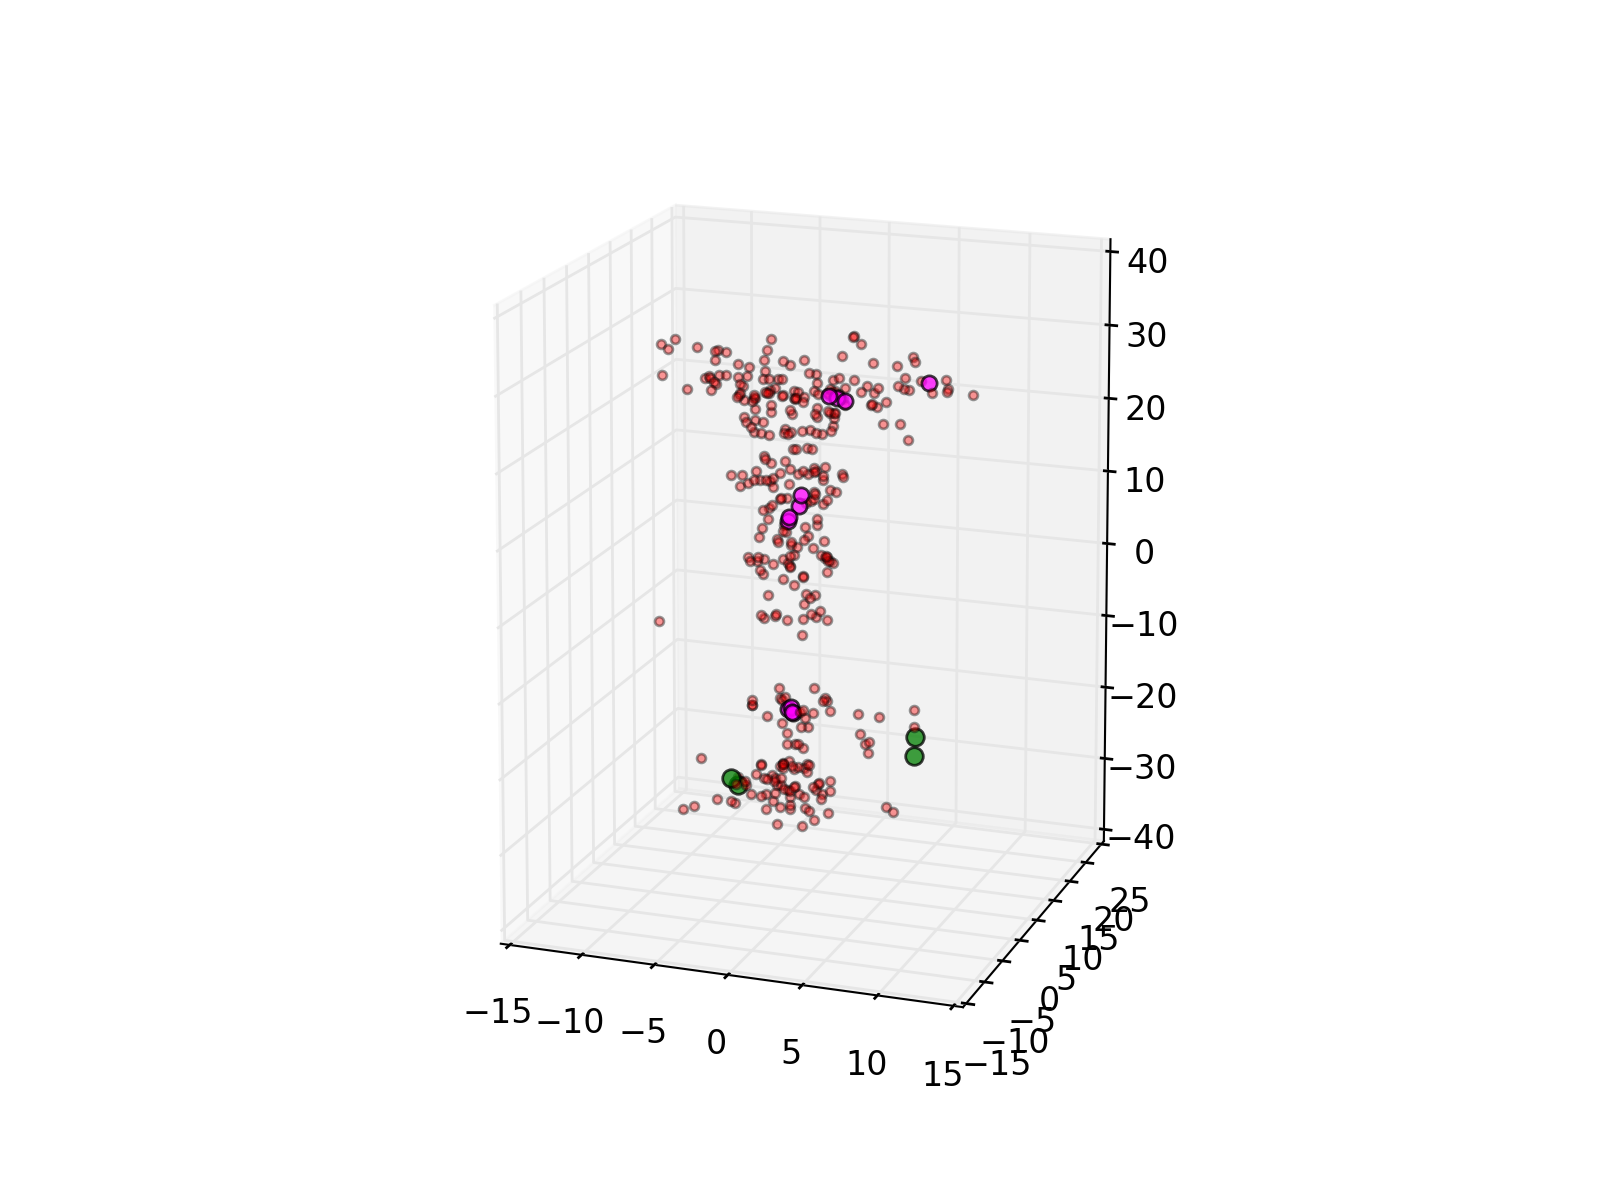

In [24]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='3d')

SolventGroups = {
    'K': K_ions,
    'CL': CL_ions,
    'OW': Water
    }

kwargs = {
    'protein': {'c': 'blue', 'alpha': 0.1},
    'K':  {'c':'magenta','s':30, 'alpha':0.75},
    'CL': {'c':'green','s':40, 'alpha':0.75},
    'OW': {'c':'red','s':10, 'alpha':0.4}
    }

for ts in u.trajectory[:4]:
    # Protein COG
    protein_cog = bb.center_of_geometry()

    # List of protein atomic coordinates
    bb_com = numpy.array([r.atoms.select_atoms(sel).center_of_geometry() for r in bb.residues])
    bb_com = translate_to_protein_cog(bb_com, protein_cog)
    
    # Lists of protein chains atomic coordinates
    chains_bb_com = list(divide_chunks(bb_com, int(bb.n_residues/bb.n_segments)))

    axis_reference_points = numpy.mean(chains_bb_com, axis=0)
    # Channel length
    channel_length = numpy.linalg.norm(axis_reference_points[-1] - axis_reference_points[0])
    # Determine direction of axis
    datamean = axis_reference_points.mean(axis=0)
    # Do an SVD on the mean-centered data.
    uu, dd, vv = numpy.linalg.svd(axis_reference_points - datamean)
    e_z = vv[0] # first principal component
    
    # Plot
    X,Y,Z = bb_com.T
#     ax.scatter(X,Y,Z,c='blue',alpha=0.4)

    for key in SolventGroups.keys():
        for atom_position in SolventGroups[key].positions:
            atom_position = translate_to_protein_cog(atom_position, protein_cog)
            distance_atom_protein = numpy.linalg.norm(bb_com - atom_position, axis=1)
            closest_protein_atom_index = list(distance_atom_protein).index( min(distance_atom_protein) )
            closest_protein_atom_position = bb_com[closest_protein_atom_index]

            if is_atom_inside_protein(atom_position, closest_protein_atom_position, e_z, channel_length):
                X,Y,Z = atom_position
                # Plot
                ax.scatter(X,Y,Z,**kwargs[key])        

fig.tight_layout()            
ax.set_aspect('equal')
plt.show()

# TO-DO

* Determine instant current per atom species
* Determine average ion flux. Compare with Aksimentiev methods.
* Edit presentation and write Latex notes on criteria for filtering of permeant particles in hybrid channels and channels spanning lipid bilayer. 

**Interesting References**

https://www.digitalocean.com/community/tutorials/how-to-use-args-and-kwargs-in-python-3

https://jovianlin.io/data-visualization-seaborn-part-3/